In [12]:
import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## prepare input data

In [13]:
# filename = 'female_names.txt'
filename = 'pokemon_names.txt'
# filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name:
            continue
        if not name.isalpha():
            continue
        names.append(name)
    return names

In [14]:
import random 
names = get_names()

In [15]:
letters = '.' + ''.join(sorted(set(''.join(names))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

In [16]:
print(letters)
print(num_letters)

.abcdefghijklmnopqrstuvwxyzé
28


## Frequency based model

In [17]:
P = torch.zeros((num_letters, num_letters))

for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]

        P[ix1][ix2] += 1

P /= P.sum(1, keepdim=True)

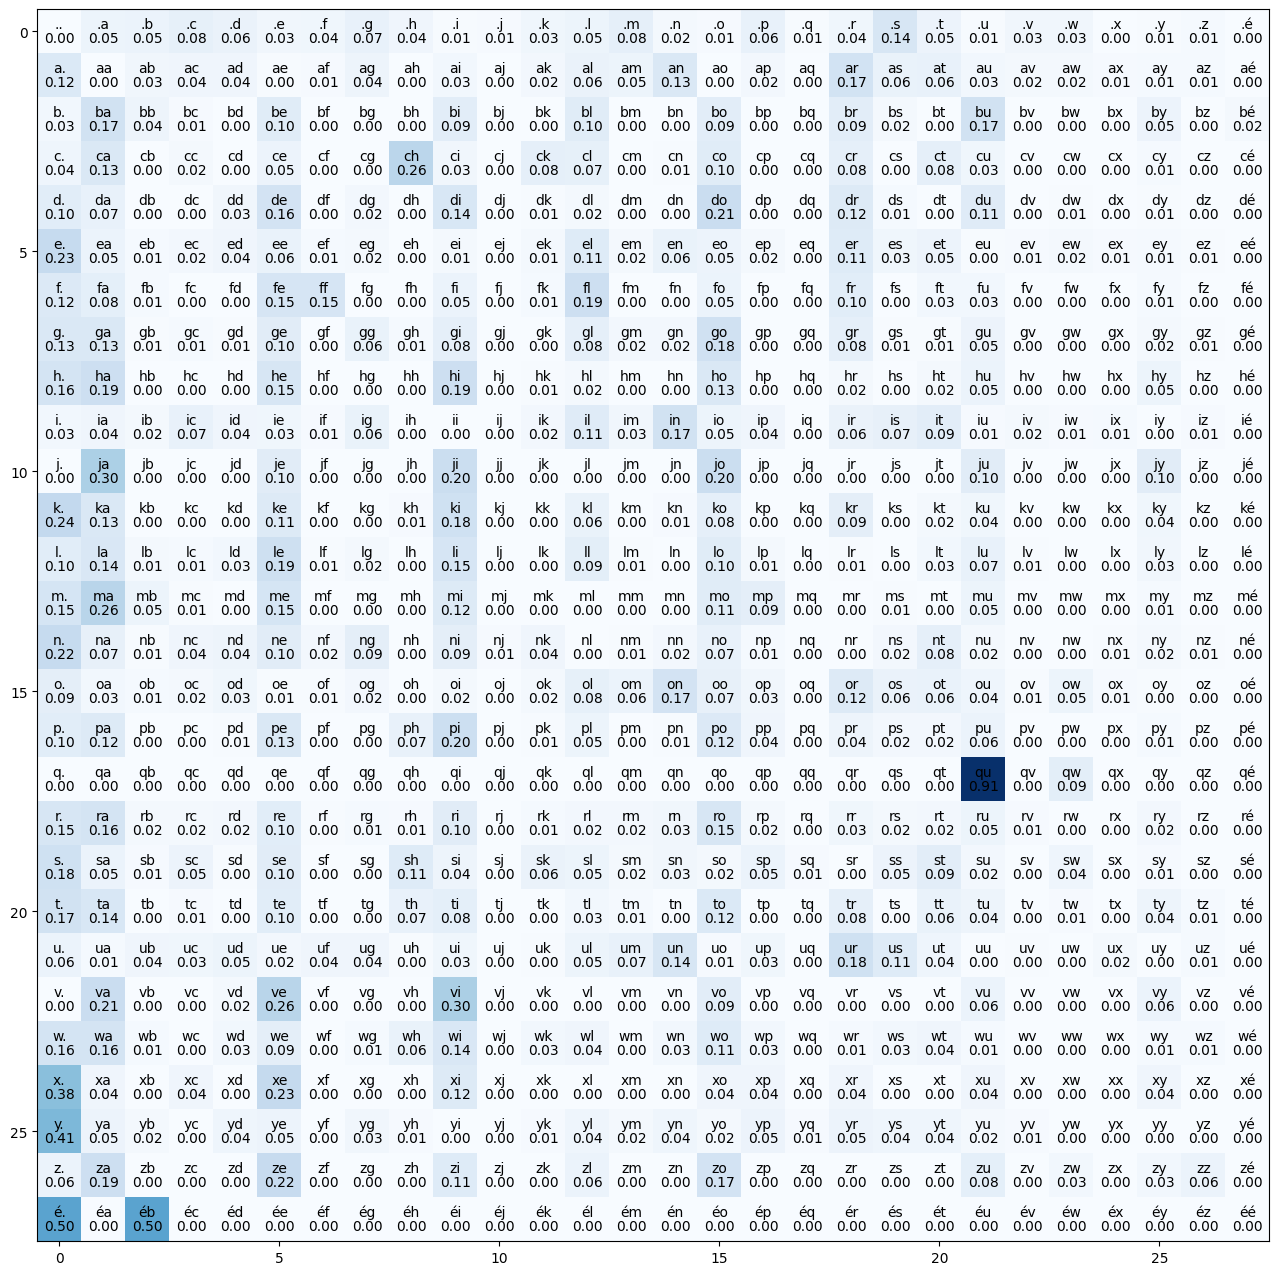

In [19]:
plt.figure(figsize=(16, 16))
plt.imshow(P, cmap='Blues')

for j in range(num_letters):
    for i in range(num_letters):
        plt.text(j, i, f"{P[i][j].item():.2f}", va='top', ha='center')
        plt.text(j, i, f"{itol[i]}{itol[j]}", va='bottom', ha='center')

In [21]:
g = torch.Generator().manual_seed(2147483647)

for i in range(100):
    letter = '.'

    word = ''

    while True:
        ix = ltoi[letter]
        probs = P[ix]

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
    print(word)

pro
bus
poriurrowilo
mongodis
ga
pintiry
sle
s
doniggageashalbipoqusillechysho
gabu
ceffur
hilielphoragnjeo
ch
g
birgmeg
aurtt
onelospt
fufbuitoon
pantyrewsoreanjorlburotfelokattakhlowtlot
stope
by
h
mole
hedoonionfff
midow
flygr
yageedo
maxyppipuslloko
t
sod
mppiniviscllbenkagins
eneom
s
figoomagrbit
lorampiagytello
lbrodomasicckaccoronack
chilluendariltasy
s
tlanalufftha
demaclis
st
chytoror
gse
dlakosiatrure
ciban
bowemeeronan
s
s
pagonghyloa
gostoscrkemedetrach
zoriogeaprounpo
hetaonely
g
shachon
ga
t
drenerestrountirrunary
st
stas
ngan
ckane
meealararro
atht
k
ici
ppoveeriwhy
se
lipilurarnkelidon
stoonger
qurar
cr
vonkiticklt
chelogyrirtrokasellie
dis
gagco
stoigintoruhufoubar
honsantatoueodurorran
g
s
ry
sungonto
mulflinun
whacink
jongrseberla
ve
nddly
anise
bloaurn
skiketon
c
swareldie
mbee
peipohinamors
maloshe
igina
lmobik
umawin
arlldo
ggy
mil


## Set up the network and train it

In [22]:
xs = []
ys = []


for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [23]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=num_letters).float()

In [24]:
W = torch.zeros((num_letters, num_letters), requires_grad=True).float()

In [28]:
for i in range(100):
    W.grad = None

    logits = xenc @ W

    assert logits.shape == (len(xs), num_letters)
    probs = logits.softmax(dim=1)

    np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)

    # the predicted probability of the correct letter
    # from our model
    ypred = probs[torch.arange(len(ys)), ys]
    loss = -(ypred.log().mean())

    if i % 10 == 0:
        print(f"Iteration {i} Loss: {loss}")
    
    loss.backward()
    W.data += -50 * W.grad

Iteration 0 Loss: 2.5883939266204834
Iteration 10 Loss: 2.5880825519561768
Iteration 20 Loss: 2.5877885818481445
Iteration 30 Loss: 2.5875115394592285
Iteration 40 Loss: 2.5872490406036377
Iteration 50 Loss: 2.5870003700256348
Iteration 60 Loss: 2.5867648124694824
Iteration 70 Loss: 2.586540699005127
Iteration 80 Loss: 2.5863280296325684
Iteration 90 Loss: 2.586125373840332


In [29]:
nlls = []

for word in ['emma']:
    for ch1, ch2 in zip(word, word[1:]):
        ix = ltoi[ch1]
        iy = ltoi[ch2]
        xenc2 = F.one_hot(torch.tensor([ix]), num_classes=num_letters).float()

        logits = xenc2 @ W
        probs = logits.softmax(dim=1)
        np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)
        nlls.append(-probs[-0, iy].log())

print(torch.tensor(nlls).mean().item())


4.182328224182129


The training loop took a few tries to get right.

It took me a long time to figure out how to index into the predictions of the network `ypred` with the expected outputs `ys`. `ypred[ys]` by itself didn't work. 

But `ypred[torch.arange(len(ys)), ys]` did work. I tried it on a small toy example, before running it on the full dataset.

I also got the loss function wrong on the first try.

`ypred` is the predicted probability of the correct letter.

I thought that since I needed `ypred` to equal 1, the loss function for each example should be:

$$ \text{Loss for one example} = 1 - \text{ypred} $$

and then for all examples it should be:

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{\log (1 - \text{ypred})} $$

But it turns out the second statement is wrong. If `ypred` equals 1, we'll end up taking $\log 0$ for each example, which is $-\infty$.

Instead, the correct loss functions are as follows:

$$ \text{Loss for one example} = -\log \text{ypred} $$

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{-\log \text{ypred}} $$

This gives us a loss of 0 when the results are perfect, and a positive loss otherwise.


## Sampling words from our model

In [36]:
g = torch.Generator().manual_seed(2147483647)

for i in range(100):
    letter = '.'

    word = ''

    while True:
        predxenc = F.one_hot(torch.tensor([ltoi[letter]]), num_classes=num_letters).float()

        logits = predxenc @ W
        assert logits.shape == (1, num_letters)
        probs = logits.softmax(dim=1)
        np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
    print(word)

pro
bus
poriurrowilo
mongodis
ga
pintiry
sle
s
doniggageashalbipoqusillechysho
gabu
ceffur
hilielphoragnkeo
ch
g
birgmeg
aurtt
onelospt
fy
duitoon
pantyrewsoreanjorlburotfelokattakhlowunnpastope
by
h
mole
hedoonionfff
midow
flygr
zealedo
maxyppipuslloko
t
sod
mppinjykolllbenkagins
eneom
s
figoomagrbit
lorampiagytello
lbrodomasicckaccoronacl
chilluendariltasy
s
tlanaluffuna
demaclis
st
chytoror
gse
ck
gosiatrurfe
m
bo
bowemeeronan
s
s
pagongizor
beppsmoloonhildus
didénjjogeaprounpo
hetaonely
g
shachon
ga
t
drenerestrountirrunary
st
stas
ngan
ckane
meealararro
atht
k
ici
ppoveeriwhy
se
lipilurarnkelidon
stoonger
qurar
cr
vonkiticklt
chelogyrirtrokasellie
dis
gagco
stojangurntavdrt
boalonsantatoueodurorran
g
s
ry
sungonto
mulflinun
wie
mepeeongrseberla
ve
nddly
anise
bloaurn
skiketon
c
swareldie
mbee
peipoipiggrot
maloshe
igina
los
hadumawin
arlldo


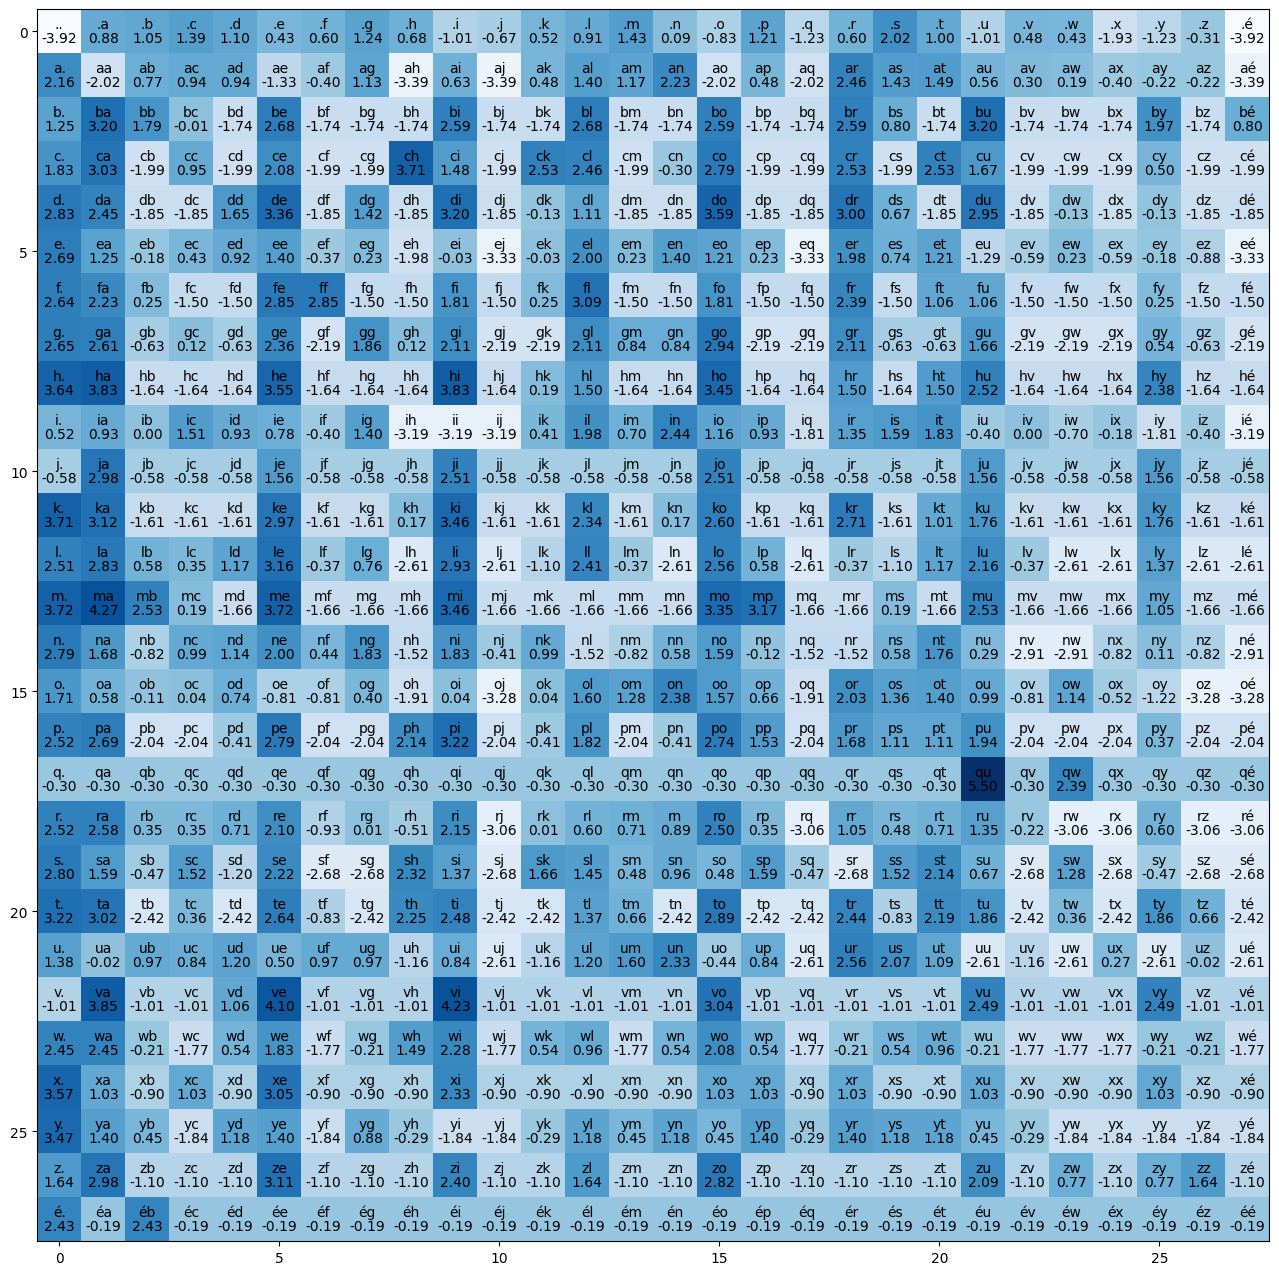

In [38]:
W2 = W.detach().numpy()
plt.figure(figsize=(16, 16))
plt.imshow(W2, cmap='Blues')
for i in range(num_letters):
    for j in range(num_letters):
        plt.text(j, i, f"{W2[i][j]:.2f}", va='top', ha='center')
        plt.text(j, i, f"{letters[i]}{letters[j]}", va='bottom', ha='center')

